In [117]:
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt
import random

## Load data

In [118]:
!wget https://raw.githubusercontent.com/ncarkaci/TDKDictionaryCrawler/master/ortak_kelimeler.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [119]:
with open("ortak_kelimeler.txt", encoding='utf-8') as f:
    text = f.read()

In [120]:
words = text.split("\n")

In [121]:
long_text = text.replace("\n","")
ids = list(set(long_text))
len(ids)

29

In [122]:
ordinal_char_pairs = sorted([(ord(c),c) for c in ids])
ordinal_char_pairs

[(97, 'a'),
 (98, 'b'),
 (99, 'c'),
 (100, 'd'),
 (101, 'e'),
 (102, 'f'),
 (103, 'g'),
 (104, 'h'),
 (105, 'i'),
 (106, 'j'),
 (107, 'k'),
 (108, 'l'),
 (109, 'm'),
 (110, 'n'),
 (111, 'o'),
 (112, 'p'),
 (114, 'r'),
 (115, 's'),
 (116, 't'),
 (117, 'u'),
 (118, 'v'),
 (121, 'y'),
 (122, 'z'),
 (231, 'ç'),
 (246, 'ö'),
 (252, 'ü'),
 (287, 'ğ'),
 (305, 'ı'),
 (351, 'ş')]

In [123]:
len(ordinal_char_pairs)

29

## Encode & Decode Functions

In [124]:
ctoi = {c:i for i,(o,c) in enumerate(ordinal_char_pairs)}
itoc =  {i:c for i,(o,c) in enumerate(ordinal_char_pairs)}

In [125]:
ctoi['.']=len(ctoi)
itoc[len(itoc)]='.'

In [126]:
def encode(input:str):
    return [ctoi[c] for c in input]

def decode(ids):
    return "".join([itoc[i] for i in ids])

In [127]:
assert decode(encode("zemberek"))=='zemberek'

## Helpers

In [128]:
def plot_training_loss(nn):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))


    axs[0].plot(nn.losses, label="Neural net train loss")
    axs[0].plot(nn.val_loss, label="Neural net val loss")
    axs[0].set_title('Losses')
    axs[0].legend()

    axs[1].plot([g[1] for g in nn.grads], label="Max")
    axs[1].plot([g[0] for g in nn.grads], label="Min")
    axs[1].plot([g[2] for g in nn.grads], label="Avg")
    axs[1].set_title('Gradients')
    axs[1].legend()

    plt.show()

## Prepare Training Data

In [129]:
def generate_data(words, block_size):
    xs, ys = [], []
    for w in words:
        context = [ctoi["."]]*block_size
        for c in w+'.':
            id = ctoi[c]

            xs.append(context)
            ys.append(id)

            context = context[1:]+[id]

    print(f"Generated {len(xs)} samples")

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)

    return xs, ys

In [130]:
random.seed(13)
random.shuffle(words)

n = len(words)
n1 = int(n*0.8)
n2 = int(n*0.9)

In [131]:
LR = 10

## Train

In [132]:
class MlpLM:
    def __init__(self, block_size, n_embd):

        self.block_size = block_size
        self.n_embd = n_embd

        self.C = torch.randn((30, self.n_embd))
        self.W1 = torch.randn((self.n_embd*self.block_size, 100))
        self.b1 = torch.randn(100)
        self.W2 = torch.randn((100, 30))
        self.b2 = torch.randn(30)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]

        # for logging
        self.losses = None
        self.val_losses = None
        self.grads = None
        self.lri = None

    def forward(self, ix):
        assert len(ix.shape) == 2
        assert ix.shape[1] == self.block_size
        batch_size = ix.shape[0]

        # 1- embeddings
        embd = self.C[ix].float()
        embd = embd.view(-1, self.block_size * self.n_embd)
        assert embd.shape == (batch_size, self.block_size * self.n_embd)

        # 2- hidden layer
        h = torch.tanh(embd@self.W1 + self.b1)
        assert h.shape == (batch_size, 100)

        logits = h@self.W2 + self.b2
        assert logits.shape == (batch_size, 30)

        # 3- softmax
        counts = logits.exp() + 1e-20
        probs = counts / counts.sum(dim=-1, keepdim=True)

        assert probs.shape == (batch_size, 30)
        for b in range(batch_size):
            assert probs[b].sum().item()-1.0 < 1e-4, f"Prob sum for batch {b} is {probs[b].sum().item()}"

        return logits, probs

    def train(self, xs, ys, xval, yval, lr=0.1, steps=1000):
        self.losses = []
        self.val_losses = []
        self.grads = []

        if lr is None:
            self.lri = []
            lre = torch.linspace(-3, 0, steps)
            lrs = 10**lre

        for p in self.parameters:
            p.requires_grad = True

        print(f"Model has {sum([p.nelement() for p in self.parameters])} parameters!")
        print(f"Using {len(xs)} samples")

        # set default loss value to zero
        loss = val_loss = torch.zeros((1))[0]

        # training loop
        for i in range(steps):
            logits, probs = self.forward(xs)

            # loss: negative log likelihood
            loss = -probs[torch.arange(len(xs)), ys].log().mean()
            loss_f = F.cross_entropy(logits, ys)
            assert abs(loss-loss_f) < 1e-3, f"Loss mismatch {loss} vs {loss_f} diff {abs(loss-loss_f)}"

            # backward
            for p in self.parameters:
                p.grad = None

            loss.backward()

            if self.lri is not None:
                lr = lrs[i]
                self.lri.append(lre[i])

            # update weights
            for p in self.parameters:
                p.data -= lr * p.grad

            # log validation loss
            if xval is not None:
                with torch.no_grad():
                    val_logits, val_probs = self.forward(xval)
                    val_loss = -val_probs[torch.arange(len(xval)), yval].log().mean()

                    val_loss_f = F.cross_entropy(val_logits, yval)
                    assert abs(val_loss-val_loss_f) < 1e-3, f"Val loss mismatch {val_loss} vs {val_loss_f} diff {abs(val_loss-val_loss_f)}"
                    
                    self.val_losses.append(val_loss.item())

            # report losses
            if steps <= 20 or i % 10 == 0:
                print(f"Step {i} | loss: {loss.item():.4f} | val loss: {val_loss.item():.4f}")

            # logging
            self.losses.append(loss.item())
            self.grads.append([
                min([p.grad.min().item() for p in self.parameters]),
                max([p.grad.max().item() for p in self.parameters]),
                sum([p.grad.mean().item()
                    for p in self.parameters])/len(self.parameters)
            ]
            )

        print(f"loss: {loss.item():.4f} validation loss: {val_loss.item():.4f}")

    def generate(self):
        reverse_offset = -self.n+1
        n_start_chars = self.n-1

        chars = torch.tensor([ctoi['.']]*n_start_chars, dtype=torch.int)

        while True:
            probs = self.forward(chars[reverse_offset:])
            assert probs.shape == (30,), f"{probs.shape=}"

            next_char = torch.multinomial(probs, 1, replacement=True)

            if next_char.item() == ctoi['.']:
                return decode(list(chars.numpy())[n_start_chars:])

            chars = torch.concat((chars, next_char), dim=-1)

### Context length 1 (Bi-gram)

In [133]:
block_size = 1
xs_train, ys_train = generate_data(words[:n1], block_size)
xs_valid, ys_valid = generate_data(words[n1:n2], block_size)
# xs_test, ys_test = generate_data(words[n2:], block_size)

Generated 293606 samples
Generated 36892 samples


In [134]:
for i in range(10):
    print(decode(list(torch.concat((xs_train[i], ys_train[i,None])).numpy())))

.p
pa
an
nt
te
ei
iz
zm
m.
.f


In [135]:
torch.manual_seed(13)
nn2 = MlpLM(1, 2)
nn2.train(xs_train[:1000], ys_train[:1000], None, None, None, 1000)

Model has 3390 parameters!
Using 1000 samples
Step 0 | loss: 19.0845 | val loss: 0.0000


Step 10 | loss: 18.5175 | val loss: 0.0000
Step 20 | loss: 17.9242 | val loss: 0.0000
Step 30 | loss: 17.3118 | val loss: 0.0000
Step 40 | loss: 16.6951 | val loss: 0.0000
Step 50 | loss: 16.0959 | val loss: 0.0000
Step 60 | loss: 15.5331 | val loss: 0.0000
Step 70 | loss: 15.0117 | val loss: 0.0000
Step 80 | loss: 14.5213 | val loss: 0.0000
Step 90 | loss: 14.0458 | val loss: 0.0000
Step 100 | loss: 13.5727 | val loss: 0.0000
Step 110 | loss: 13.0953 | val loss: 0.0000
Step 120 | loss: 12.6109 | val loss: 0.0000
Step 130 | loss: 12.1203 | val loss: 0.0000
Step 140 | loss: 11.6279 | val loss: 0.0000
Step 150 | loss: 11.1434 | val loss: 0.0000
Step 160 | loss: 10.6826 | val loss: 0.0000
Step 170 | loss: 10.2584 | val loss: 0.0000
Step 180 | loss: 9.8690 | val loss: 0.0000
Step 190 | loss: 9.5022 | val loss: 0.0000
Step 200 | loss: 9.1497 | val loss: 0.0000
Step 210 | loss: 8.8124 | val loss: 0.0000
Step 220 | loss: 8.4963 | val loss: 0.0000
Step 230 | loss: 8.2060 | val loss: 0.0000
Ste

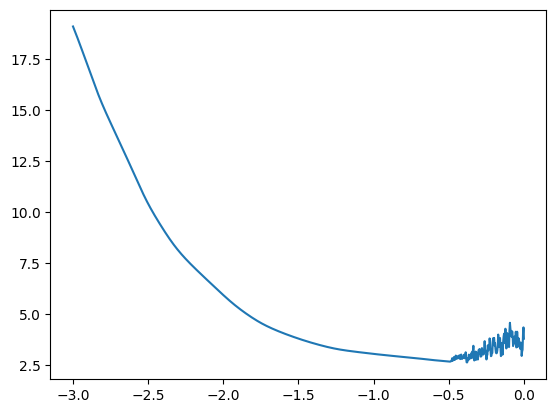

In [136]:
plt.plot(nn2.lri, nn2.losses)

In [137]:
10**-0.5

0.31622776601683794

In [138]:
torch.manual_seed(13)
nn2 = MlpLM(1, 2)
nn2.train(xs_train, ys_train, xs_valid, ys_valid, 0.3, 300)

Model has 3390 parameters!
Using 293606 samples


Step 0 | loss: 19.1857 | val loss: 12.6542
Step 10 | loss: 4.4035 | val loss: 4.2943
Step 20 | loss: 3.7062 | val loss: 3.6806
Step 30 | loss: 3.4425 | val loss: 3.4301
Step 40 | loss: 3.3182 | val loss: 3.3117
Step 50 | loss: 3.2334 | val loss: 3.2288
Step 60 | loss: 3.1712 | val loss: 3.1681
Step 70 | loss: 3.1253 | val loss: 3.1234
Step 80 | loss: 3.0880 | val loss: 3.0872
Step 90 | loss: 3.0559 | val loss: 3.0563
Step 100 | loss: 3.0267 | val loss: 3.0281
Step 110 | loss: 2.9980 | val loss: 3.0003
Step 120 | loss: 2.9674 | val loss: 2.9703
Step 130 | loss: 2.9331 | val loss: 2.9364
Step 140 | loss: 2.8973 | val loss: 2.9007
Step 150 | loss: 2.8633 | val loss: 2.8665
Step 160 | loss: 2.8326 | val loss: 2.8355
Step 170 | loss: 2.8054 | val loss: 2.8081
Step 180 | loss: 2.7819 | val loss: 2.7845
Step 190 | loss: 2.7618 | val loss: 2.7644
Step 200 | loss: 2.7450 | val loss: 2.7475
Step 210 | loss: 2.7313 | val loss: 2.7338
Step 220 | loss: 2.7204 | val loss: 2.7230
Step 230 | loss: 2.7

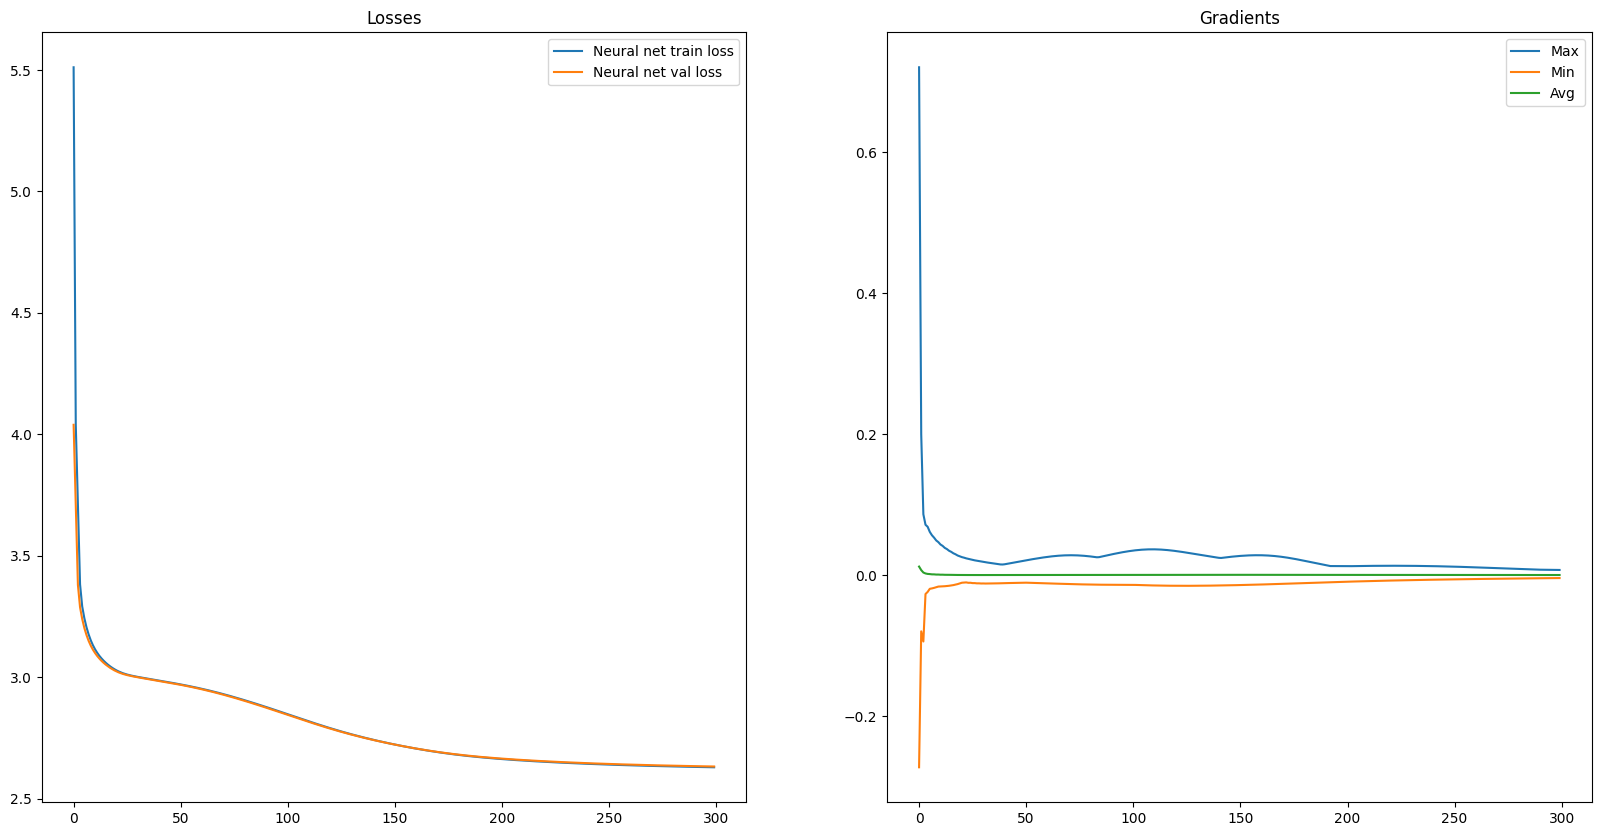

In [ ]:
plot_training_loss(nn2)